This script takes Texas Education Agency data about school district demographics and disciplinary actions, and puts them together in one CSV file for the Texas Appleseed "School to Prison Pipeline" map. See http://www.texasdisciplinelab.org/

To use the script, follow these instructions:

1. For every year that you want to cover, download all 20 of the region files from http://rptsvr1.tea.texas.gov/adhocrpt/Disciplinary_Data_Products/Download_Region_Districts.html and put them in the directory '../data/from_agency/by_region/'

2. For every year that you want to cover, download the "District and Charter Detail Data" Snapshot Data File (comma-delimited *.dat)" from https://rptsvr1.tea.texas.gov/perfreport/snapshot/download.html. The website automatically delivers these files with the same filename: district.dat. You will need to rename them to have different names by adding the year after "district". For instance, "district2016.dat"

3. Change the first_year and last_year variables below to reflect the years you want your file to cover.

4. Run the notebook with "Kernel -> Restart and Run All"

5. Wait a while for it to finish. After about 5 minutes, the notebook should produce 'schoolToPrison_flat.csv' in the '../data/processed/' directory.

The map needs a (GeoJSON or TopoJSON) file of district shapes, and it needs a way to select data from the CSV and populate the map with it based on a user's input. This notebook doesn't solve that problem; it only makes the CSV. The resulting file will be about 5.2 MB for 2006-2016. The GeoJSON or TopoJSON file will take additional memory.

The output CSV will have 2 index rows, for the school district's ID number and the year. Then there are 90 more rows as follows:

for each of the 10 demographic groups ('SPE', 'ECO','HIS','BLA', 'WHI','IND', 'ASI','PCI', 'TWO', 'ALL'):
   
    * there's one 'POP' column showing the population of that group within the district
   
    * there are four punishment columns ('EXP','DAE','ISS','OSS') showing how many times a member of that group received the specified punishment in the district in one year
   
    * there are four scale columns ('EXP-S','DAE-S','ISS-S','OSS-S') showing what color the district should be filled with on the map, to represent whether the group's treatment was statistically significant in favor of the group or against. The scale is from -6 to 6, with negative numbers representing fewer than average punishments and positive numbers representing more than average.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

first_year = 2006 # the year 2006 is the first year on the TEA site
last_year = 2016

pdict = {"EXPULSIONS":"EXP","DAEP REMOVALS":"DAE","IN SCHOOL SUSPENSIONS":"ISS","OUT OF SCHOOL SUSPENSIONS":"OSS"}

demos = {'SPE', 'ECO','HIS','BLA', 'WHI','IND', 'ASI','PCI', 'TWO', 'ALL'}

In [2]:
def formatDF(apple, year, year_col):
    
    # Removes columns not needed for the map
    
    apple = apple.drop(["AGGREGATION LEVEL","REGION","DISTNAME"], axis = 1)
    
    # Keeping only the rows that categorize students by protected class, or that have totals.
    
    patternIn = "WHITE|AFRICAN AMERICAN|AMERICAN INDIAN OR ALASKA NAT|HISPANIC|NATIVE HAWAIIAN|ASIAN" +\
                "|TWO OR MORE RACES|SPEC. ED|ECO. DISAD|ECO DISAD.|TOTAL|DISTRICT CUMULATIVE YEAR END ENROLLMENT" +\
                "|MANDATORY|DISCRETIONARY|NATIVE AMERICAN"
    
    apple = apple[apple["HEADING NAME"].str.contains(patternIn)]
    
    # Getting rid of rows that count students instead of incidents, or non-disadvantaged kids.
    
    patternOut = "SPEC. ED. STUDENTS|EXPULSIONS TO JJAEP|ECO DISAD. STUDENTS|ECO. DISAD. STUDENTS" +\
                 "|AT RISK|NON AT|UNKNOWN AT|NON ECO DISAD.|NON ECO. DISAD."
    apple = apple[apple["HEADING NAME"].str.contains(patternOut) == False]

    # Delete rows appearing to double-count the same expulsions.
    
    JJAEPReplace = {"SECTION": {
                        'M-ECO\. DISADV\. JJAEP PLACEMENTS|H-SPEC\. ED\. JJAEP EXPULSIONS': 'C-JJAEP EXPULSIONS'}}
    apple = apple.replace(to_replace=JJAEPReplace, regex=True)
    apple = apple[apple["SECTION"].str.contains("JJAEP EXPULSIONS|DISCIPLINE ACTION COUNTS") == False]
    
    # Consolidating some of the descriptors into broader categories
    
    appleReplace = {year_col:
                        {-99999999: 1, -999999: 1, -999: 1},
                    "SECTION": {
                        'A-PARTICIPATION': 'POP',
                        'D-EXPULSION ACTIONS|N-ECO\. DISADV\. EXPULSIONS|I-SPEC\. ED\. EXPULSIONS': 'EXP',
                        'E-DAEP PLACEMENTS|O-ECO\. DISADV\. DAEP PLACEMENTS|J-SPEC\. ED\. DAEP PLACEMENTS': 'DAE',
                        'F-OUT OF SCHOOL SUSPENSIONS|P-ECO\. DISADV\. OUT OF SCHOOL SUS.|K-SPEC\. ED\. OUT OF SCHOOL SUS\.': 'OSS',
                        'G-IN SCHOOL SUSPENSIONS|Q-ECO\. DISADV\. IN SCHOOL SUS\.|L-SPEC\. ED\. IN SCHOOL SUS\.': 'ISS'},
                    "HEADING NAME": {'SPEC\. ED.*$': 'SPE',
                                     'ECO?. DISAD.*$': 'ECO',
                                     'HIS(PANIC)?/LATINO': 'HIS',
                                     'HISPANIC': 'HIS',
                                     '(BLACK)?( OR |/)?AFRICAN AMERICAN': 'BLA',
                                     'WHITE': 'WHI',
                                     'NATIVE AMERICAN':'IND',
                                     'AMERICAN INDIAN OR ALASKA NAT': 'IND',
                                     'ASIAN': 'ASI',
                                     'NATIVE HAWAIIAN/OTHER PACIFIC': 'PCI',
                                     'TWO OR MORE RACES': 'TWO',
                                     'DISTRICT CUMULATIVE YEAR END ENROLLMENT': 'ALL'
                                    }
                    }

    df = apple.replace(to_replace=appleReplace, regex=True)
    
    df["Year"] = year

    for punishment in pdict:
        for category in ("MANDATORY ", "DISCRETIONARY "):
            df.loc[((df['HEADING NAME'] == category + punishment), 'SECTION')] = category + pdict[punishment]
            df = df.replace(to_replace=category + punishment, value="ALL")

    return df


In [3]:
def populations(districtPath, year):
    district = pd.read_csv(districtPath)

    district = district.rename(columns = {"SNAPDIST": 'DISTNAME'})
    
    sometimes_missing = [ 'DPETINDP', 'DPETASIP', 'DPETPCIP', 'DPETTWOP']
    
    for c in sometimes_missing:
        if c not in district.columns:
            district[c] = np.nan
    
    if "COMMTYPE" not in district.columns:
        district["COMMTYPE"] = ""
    
    charters = district[district["COMMTYPE"] == "Charters"]["DISTRICT"]
        
    # deleting redundant columns
    
    district["Year"] = year
    
    # dropping 'DPETALLC', which is also a measure of district population, but it's not
    # the same as what the TEA uses in the annual discipline reports processed above.
    
    district = district[['DISTRICT', 'Year', 'DPETSPEP',
                         'DPETBLAP', 'DPETHISP', 'DPETWHIP', 'DPETINDP',
                         'DPETASIP', 'DPETPCIP', 'DPETTWOP', 'DPETECOP']] 

    district = district.set_index(["DISTRICT",'Year'])
    
    # turning percentages into decimals

    district = district * .01

    return district, charters

In [4]:
def impossible(distPop, racePop, all_punishments, group_punishments):

    """
    >>> print(impossible(50, 20, 20, 100))
    1
    >>> impossible(20, 0, 20, 0)
    0
    """

    # flags implausible data entries. Some of them could still be true if school administrators
    # applied different standards different standards to determine which students belong to which demographic group.
    # Or some could be the result of students not being counted because of the time they moved in and out of district.

    if group_punishments > max(all_punishments,8): # eight because TEA could report 2 masked columns with 4 each
        return 1
    if racePop == 0 and group_punishments > 0:
        return 1
    return 0



def getFisher(row, state_pop, state_punishments, d, p):
    
    # I don't know if this is a valid way to report the Fisher's 
    # exact test statistic, but the idea is that if getFisher returns a
    # positive number over .95, there's a 95% chance that the group's 
    # better-than-average treatment is not due to chance.
    # If it returns a number under -.95, there's a 95% chance that 
    # the group's worse-than-average treatment is not due to chance.
    # I think it should be easier to create a color scale to show 
    # the scores on a map this way.

    # The getFisher function assumes wrongly that everyone can have only 
    # one punishment (of each type). If the number of
    # punishments exceeds the number of kids, it reduces the number 
    # of punishments (and assumes wrongly that every
    # kid has been punished) But maybe the results are still close enough to correct to use for scaling?

    if d == "ALL":
        distPop = state_pop # variable names are misleading in the "ALL" case
        all_punishments = state_punishments
        
    else:
        distPop = row[("ALL", "POP")]
        all_punishments = row[("ALL", p)]
    
    racePop = row[(d, "POP")]
    group_punishments = row[(d, p)]
    if pd.isna(group_punishments):
            group_punishments = 0
    if pd.isna(racePop):
        racePop = group_punishments
        
    # If the impossible function returns True, the value reported by the TEA will be replaced with NaN.
    # A previous version preserved the value reported by the TEA and added separate columns to indicate
    # whether they were "impossible".
        
    if impossible(distPop, racePop, all_punishments, group_punishments):
        return None
    
    if max(racePop, group_punishments) == 0 or None:
        return None
    if distPop == 0 or pd.isna(distPop):
        return None
    elif max(group_punishments, all_punishments) == 0 or None:
        return 0
    else:
        if pd.isna(all_punishments):
            all_punishments = 0
        try: 
            oddsratio, pvalueG = stats.fisher_exact([[racePop, max(distPop - racePop, 0)],
                                                 [group_punishments, max(all_punishments - group_punishments, 0)]],
                                                alternative='greater')
        except ValueError:
            print(distPop, racePop, all_punishments, group_punishments)
        oddsratio, pvalueL = stats.fisher_exact([[racePop, max(distPop - racePop, 0)],
                                                 [group_punishments, max(all_punishments - group_punishments, 0)]],
                                                alternative='less')
        if pvalueL < pvalueG:
            pv = 1 - pvalueL
        else:
            pv = pvalueG - 1
        
        # To save space in the output file, this simplifies the decimal values to an integer from -6 to 6
        # It should replace similar code in txappleseedmap/js/index.js
        
        scale = 0
        scale_colors = (-0.99999,-0.998,-0.97,-0.84,-0.3,0.3,0.84,0.97,0.998,0.99999)
        
        for v in scale_colors:
            if pv > v:
                scale += 1
        
    return scale

# print(getFisher(20, 5, 20, 10))

In [5]:
def getYear(year):
    year_col = "YR{}".format(str(year)[-2:])
    apple_path = '../data/from_agency/by_region/REGION_{}_DISTRICT_summary_{}.csv'
    one_year = [pd.read_csv(apple_path.format(str(region).zfill(2),str(year)[-2:]), 
                            dtype = {year_col: int})
                for region in range(1,21)]
    a = pd.concat(one_year)
    
    df = formatDF(a, year, year_col).rename(columns={year_col: "Count"})
    
    dfpivot = df.pivot_table(index=['DISTRICT','Year'], columns=['HEADING NAME', 'SECTION'], values='Count')
    
    # Trying two methods to get total disciplinary actions per district: adding up "Mandatory" and "Discretionary"
    # actions (which are not always reported), and adding up actions against special ed and non-special ed students.
    # Relying on whichever number is higher, on the assumption that if actions are reported anywhere, they probably
    # really happened.

    for p in pdict.values():
        try:
            dfpivot["ALL", p] = dfpivot["ALL"]["DISCRETIONARY " + p] + dfpivot["ALL"]["MANDATORY " + p]
        except KeyError:
            print("No mandatory/discretionary columns for " + p + " in " + str(year))
        dfpivot["ALLS", p] = dfpivot["SPE"][p] + dfpivot["NON SPE"][p]
        dfpivot = dfpivot.drop("DISCRETIONARY " + p, axis=1, level=1)
        dfpivot = dfpivot.drop("MANDATORY " + p, axis=1, level=1)
        try:
            dfpivot["ALL", p] = dfpivot[[("ALL", p), ("ALLS", p)]].max(axis=1)
        except KeyError:
            dfpivot["ALL", p] = dfpivot["ALLS", p]
    
    # Dropping columns that were just used to get totals, and won't be needed for the map.
    # And sorting columns back into order
    
    dfpivot = dfpivot.drop("ALLS", axis=1, level=0).drop("NON SPE", axis=1, level=0).sort_index(axis=1)
    
    districtPath = '../data/from_agency/districts/district{}.dat'.format(year)
    district, charters = populations(districtPath, year)

    dfwide = pd.concat([dfpivot, district], axis=1, join='outer')
    
    # adding population for each demographic group
    
    for demo in demos:
        if demo != "ALL":
            dfwide[demo, "POP"] = dfwide[[("ALL", "POP"), ("DPET" + demo + "P")]].prod(axis=1).round(0)
    
    dfpivot = dfwide.drop(columns=["DPETBLAP","DPETHISP","DPETWHIP","DPETINDP","DPETASIP","DPETPCIP","DPETTWOP","DPETECOP","DPETSPEP"])
    dfpivot = dfpivot.sort_index(axis=1)
    
    state_pop = dfpivot[("ALL", "POP")].sum()
    
    statewide_year = {}
    
    for p in pdict.values():
        statewide_year[p] = {}
        state_punishments = dfpivot[("ALL", p)].sum()
        for d in demos:
            try:
                statewide_year[p][d] = int(dfpivot[(d, p)].sum())
                dfpivot[(d, p, "S")] = dfpivot.apply(getFisher, axis = 1, args = (state_pop, state_punishments, d, p))
            except KeyError:
                dfpivot[(d, p, "S")] = np.nan # these blank column are needed to make the dataframes merge
                dfpivot[(d, p)] = np.nan
                print("{} {} not found for year {}".format(d, p, year))
            
    dfpivot = dfpivot.sort_index(axis=1).astype(float)
    
    return dfpivot, charters, statewide_year

In [6]:
# %load_ext line_profiler
# %lprun -f getFisher getYear(2006)

In [8]:
years = [x for x in range(first_year, last_year + 1)]

df_list = []
charterSeries = pd.Series([])
statewide = {}

for year in years:
    print("starting " + str(year))
    df, charters, statewide_year = getYear(year)
    df_list.append(df)
    statewide[year] = statewide_year
    charterSeries = charterSeries.append(charters)

starting 2006
TWO EXP not found for year 2006
PCI EXP not found for year 2006
TWO DAE not found for year 2006
PCI DAE not found for year 2006
TWO ISS not found for year 2006
PCI ISS not found for year 2006
TWO OSS not found for year 2006
PCI OSS not found for year 2006
starting 2007
TWO EXP not found for year 2007
PCI EXP not found for year 2007
TWO DAE not found for year 2007
PCI DAE not found for year 2007
TWO ISS not found for year 2007
PCI ISS not found for year 2007
TWO OSS not found for year 2007
PCI OSS not found for year 2007
starting 2008
TWO EXP not found for year 2008
PCI EXP not found for year 2008
TWO DAE not found for year 2008
PCI DAE not found for year 2008
TWO ISS not found for year 2008
PCI ISS not found for year 2008
TWO OSS not found for year 2008
PCI OSS not found for year 2008
starting 2009
TWO EXP not found for year 2009
PCI EXP not found for year 2009
TWO DAE not found for year 2009
PCI DAE not found for year 2009
TWO ISS not found for year 2009
PCI ISS not foun

In [9]:
all_years = pd.concat(df_list)

In [10]:
df = all_years.reset_index()
no_charters = df[~df['DISTRICT'].isin(charters)].set_index(["DISTRICT","Year"])
charters_only = df[df['DISTRICT'].isin(charters)].set_index(["DISTRICT","Year"])

In [11]:
len(all_years)

13487

In [12]:
len(no_charters)

11797

In [13]:
# changing column names to something without a comma in them

def renameTupleColumns(df):
    column_names = {c: '-'.join(c) for c in df}
    return df.rename(column_names, axis='columns')

no_charters = renameTupleColumns(no_charters)
charters_only = renameTupleColumns(charters_only)

In [33]:
import json
with open("../geojson/base_districts.geojson") as json_data:
    district_map = json.load(json_data)
    json_data.close()

In [34]:
# Testing to make sure none of the charter district numbers have corresponding
# regions on the map.

map_district_numbers = {feature["properties"]["DISTRICT_N"] for feature in district_map["features"]}
charter_district_numbers = set(charters_only.index.get_level_values(0))

assert len(map_district_numbers & charter_district_numbers) == 0

In [16]:
no_charters.to_csv("../data/processed/schoolToPrison_flat.csv", float_format='%.0f')

In [17]:
charters_only.to_csv("../data/processed/charters_flat.csv", float_format='%.0f')

In [18]:
no_charters[:2]

,,ALL-DAE,ALL-DAE-S,ALL-EXP,ALL-EXP-S,ALL-ISS,ALL-ISS-S,ALL-OSS,ALL-OSS-S,ALL-POP,ASI-DAE,ASI-DAE-S,ASI-EXP,ASI-EXP-S,ASI-ISS,ASI-ISS-S,ASI-OSS,ASI-OSS-S,ASI-POP,BLA-DAE,BLA-DAE-S,BLA-EXP,BLA-EXP-S,BLA-ISS,BLA-ISS-S,BLA-OSS,BLA-OSS-S,BLA-POP,ECO-DAE,ECO-DAE-S,ECO-EXP,ECO-EXP-S,ECO-ISS,ECO-ISS-S,ECO-OSS,ECO-OSS-S,ECO-POP,HIS-DAE,HIS-DAE-S,HIS-EXP,HIS-EXP-S,HIS-ISS,HIS-ISS-S,HIS-OSS,HIS-OSS-S,HIS-POP,IND-DAE,IND-DAE-S,IND-EXP,IND-EXP-S,IND-ISS,IND-ISS-S,IND-OSS,IND-OSS-S,IND-POP,PCI-DAE,PCI-DAE-S,PCI-EXP,PCI-EXP-S,PCI-ISS,PCI-ISS-S,PCI-OSS,PCI-OSS-S,PCI-POP,SPE-DAE,SPE-DAE-S,SPE-EXP,SPE-EXP-S,SPE-ISS,SPE-ISS-S,SPE-OSS,SPE-OSS-S,SPE-POP,TWO-DAE,TWO-DAE-S,TWO-EXP,TWO-EXP-S,TWO-ISS,TWO-ISS-S,TWO-OSS,TWO-OSS-S,TWO-POP,WHI-DAE,WHI-DAE-S,WHI-EXP,WHI-EXP-S,WHI-ISS,WHI-ISS-S,WHI-OSS,WHI-OSS-S,WHI-POP
DISTRICT,Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1902,2006,NaN,0.0,NaN,4.0,73.0,0.0,6.0,0.0,653.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,653.0,NaN,0.0,NaN,0.0,1.0,1.0,NaN,4.0,91.0,NaN,0.0,NaN,0.0,28.0,4.0,1.0,4.0,263.0,NaN,0.0,NaN,0.0,1.0,4.0,NaN,5.0,26.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,653.0,NaN,0.0,NaN,0.0,28.0,9.0,1.0,6.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,653.0,1.0,5.0,NaN,0.0,67.0,8.0,6.0,6.0,529.0
1903,2006,19.0,1.0,NaN,3.0,479.0,3.0,13.0,0.0,1491.0,NaN,0.0,NaN,0.0,1.0,0.0,NaN,0.0,1491.0,1.0,4.0,NaN,0.0,100.0,10.0,6.0,9.0,134.0,6.0,3.0,NaN,0.0,253.0,8.0,6.0,4.0,710.0,1.0,6.0,NaN,0.0,25.0,6.0,NaN,4.0,75.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,1491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1491.0,8.0,8.0,NaN,0.0,155.0,10.0,5.0,7.0,253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1491.0,14.0,3.0,NaN,0.0,352.0,0.0,7.0,2.0,1282.0


In [35]:
# Making a geoJSON to export with just one demographic group in just the latest year.

keys_to_delete = ('DISTRICT', 'DISTRICT_1', 'DISTRICT_C', 'NAME2', 'OBJECTID', 'OBJECTID_1', 'OBJECTID_2',  'REGION')

JSON_to_TEA = {"ALL-OSS": 'allActions', "ALL-POP": "allPop", "BLA-OSS": 'groupActions',
              "BLA-POP": "groupPop", "BLA-OSS-S": "disparity"}

def stat_for_JSON(column_name, j_name, district_number):
    try:
        v = no_charters.loc[(district_number, last_year), column_name]
    except:
        print(f"District {district_number} not found")
        return np.nan
    return v
            
for district in district_map["features"]:
    district_number = district['properties']['DISTRICT_N']
    for column_name in JSON_to_TEA:
        j_name = JSON_to_TEA[column_name]
        v = stat_for_JSON(column_name, j_name, district_number)
        if pd.notna(v):
            district['properties'][j_name] = int(v)
    for k in keys_to_delete:
        district['properties'].pop(k, None)

District 167903 not found
District 167903 not found
District 167903 not found
District 167903 not found
District 167903 not found


In [36]:
with open('../geojson/districts_with_default_data.geojson', 'w') as fp:
    json.dump(district_map, fp, default=int)
    fp.close()

In [21]:
# Making a dict to turn into a JSON to supply the map with different data when user
# changes the map settings.

# Building the dict from the dataframe this way takes about 10 minutes. 
# Try pivoting the dataframe to use one of the default JSON export options instead.

j = {}

for district in district_map["features"]:
    district_number = district['properties']['DISTRICT_N']
    j[district_number] = {}
    for year in range(first_year, last_year + 1):
        j[district_number][year] = {}
        for demo in demos:
            j[district_number][year][demo] = {}
            for p in pdict.values():
                try:
                    j[district_number][year][demo][p] = {}
                    if pd.notna(no_charters.loc[(district_number, year), f"{demo}-{p}"]):
                        j[district_number][year][demo][p]["C"] = \
                            int(no_charters.loc[(district_number, year), f"{demo}-{p}"])
                    if pd.notna(no_charters.loc[(district_number, year), f"{demo}-{p}-S"]):
                        j[district_number][year][demo][p]["S"] = \
                            int(no_charters.loc[(district_number, year), f"{demo}-{p}-S"])
                except:
                    if demo == "ALL" and p == "OSS": # reduce number of error messages
                        print(f"District {district_number} year {year} not found")
                if j[district_number][year][demo][p] == {}:
                    j[district_number][year][demo].pop(p, None)
            if j[district_number][year][demo] == {}:
                    j[district_number][year].pop(demo, None)

District 167903 year 2015 not found
District 167903 year 2016 not found


In [22]:
j[0] = statewide

In [23]:
with open('../data/processed/no_charters.json', 'w') as fp:
    json.dump(j, fp, default=int)
    fp.close()

In [24]:
import matplotlib.pyplot as plt


In [25]:
% matplotlib inline

### Actions taken, by demographic group, total for all years

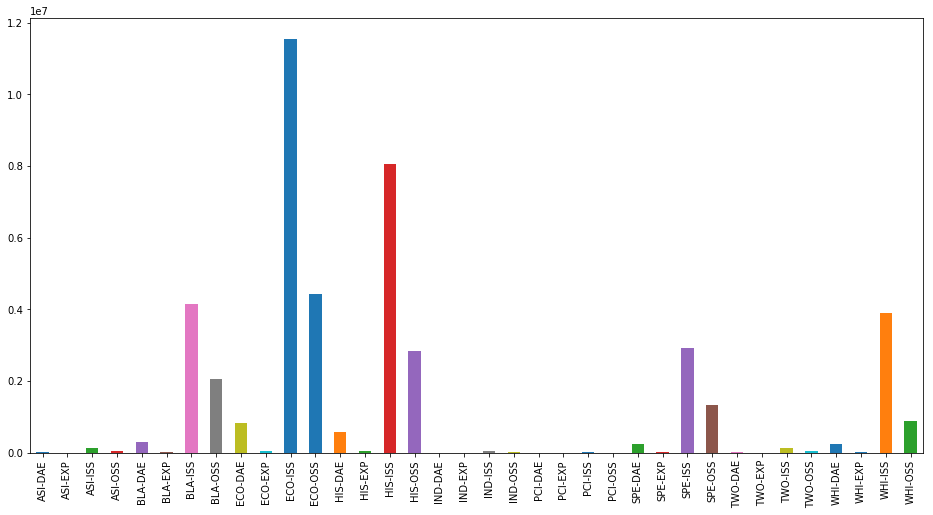

In [26]:
indexer = [c for c in no_charters.columns if len(c) == 7 if c[:3] != "ALL" if c[-3:] != "POP"]
no_charters[indexer].sum(axis=0).plot(kind = 'bar', figsize = (16,8)) 

In [27]:
# Checking to see how to restore the column MultiIndex
# but the output CSV just has a regular index for the columns (dtype: string)

m = pd.MultiIndex.from_tuples(dfpivot.columns)

NameError: name 'dfpivot' is not defined

In [ ]:
df = dfwide.set_axis(m, axis = 1, inplace=False)

In [ ]:
dfpivot = dfpivot.reset_index()

In [ ]:
dfpivot = dfpivot.sort_index(axis=1)

In [ ]:
dfpivot[:5]

In [ ]:
# This function's unused now.

def getRatio(distPop, racePop, all_punishments, group_punishments):
    # Calculating ratio of punishments for the demographic group compared to the punishments for the student population
    # as a whole. For instance, "0.505" in the disparity column indicates the group got the punishment 50.5% as often
    # as average for the student population.

    """
    >>> getRatio(200, 20, 20, 10)
    4.0
    >>> getRatio(200, 20, 20, 2)
    0.0
    >>> print(getRatio(200, 0, 20, 0))
    None
    """

    if max(racePop, group_punishments) == 0 or None:
        return None
    elif all_punishments == 0 or None:
        return 0
    else:
        disparity = (group_punishments / (max(all_punishments, group_punishments))
                     / (max(racePop, group_punishments) / distPop)) - 1
        disparity = Decimal(disparity)
        disparity = disparity.quantize(Decimal('0.01'))
    return float(disparity)